In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH

from gptchem.plotsettings import *

%matplotlib inline

## Load results

In [20]:
all_out = glob("out/**/*.pkl")

In [21]:
all_out = [load_pickle(p) for p in all_out]

In [22]:
all_out

[{'train_size': 10,
  'predictions': (#159) [1,1,1,1,1,1,1,1,1,1...],
  'xgboost': {'accuracy': 0.7547169811320755,
   'acc_macro': 0.7547169811320755,
   'racc': 0.7547169811320755,
   'kappa': 0.0,
   'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1]),
   'f1_macro': 0.43010752688172044,
   'f1_micro': 0.7547169811320755,
   'frac_valid': 1.0,
   'all_y_true': (#159) [0,1,0,1,1,1,1,1,1,1...],
   'all_y_pred': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1]),
   'valid_indices': [0

In [23]:
extracted_res = []
xgboost_results = []
tabpfn_results = []
dummy_results = []

for out in all_out:
    res = {
        "train_size": out["train_size"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
    }

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgboost"]["accuracy"],
        "f1_macro": out["xgboost"]["f1_macro"],
        "f1_micro": out["xgboost"]["f1_micro"],
        "kappa": out["xgboost"]["kappa"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn"]["accuracy"],
        "f1_macro": out["tabpfn"]["f1_macro"],
        "f1_micro": out["tabpfn"]["f1_micro"],
        "kappa": out["tabpfn"]["kappa"],
    }


    extracted_res.append(res)
    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)


In [24]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [25]:
grouped_res = res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [26]:
grouped_xgboost_res = xgboost_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [27]:
grouped_tabpfn_res = tabpfn_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [28]:
grouped_res.loc[:]

frac_valid                  accuracy                            \
                 mean  std count  sem      mean       std count       sem   
train_size                                                                  
10                1.0  0.0    11  0.0  0.732419  0.050343    11  0.015179   
20                1.0  0.0    10  0.0  0.728859  0.051230    10  0.016200   
50                1.0  0.0    10  0.0  0.740336  0.026706    10  0.008445   
100               1.0  0.0     9  0.0  0.777778  0.026127     9  0.008709   
150               1.0  0.0     8  0.0  0.835526  0.099215     8  0.035078   

            f1_macro                            f1_micro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.425792  0.007215    11  0.002175  0.732419  0.050343    11   
20          0.482033  0.038602    10  0.012207  0.728859  0.051230    10   
50          0.513919  0.059430    10  0.018793  0.740336  0.026706    10   
100         0.632455  0.057007     9  0.019002  0.777778  0.026127     9   
150         0.743894  0.157807     8  0.055793  0.835526  0.099215     8   

                         kappa                            
                 sem      mean       std count       sem  
train_size                                                
10          0.015179 -0.029611  0.055473    11  0.016726  
20          0.016200  0.036366  0.058814    10  0.018599  
50          0.008445  0.083508  0.094243    10  0.029802  
100         0.008709  0.287743  0.097927     9  0.032642  
150         0.035078  0.501270  0.306533     8  0.108376

In [29]:
grouped_tabpfn_res

accuracy                            f1_macro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.758719  0.010626    11  0.003204  0.458873  0.035479    11   
20          0.765101  0.021690    10  0.006859  0.546554  0.078797    10   
50          0.775630  0.016357    10  0.005173  0.580343  0.101826    10   
100         0.826087  0.030744     9  0.010248  0.708851  0.084392     9   
150         0.802632  0.061314     8  0.021678  0.688395  0.111860     8   

                      f1_micro                               kappa            \
                 sem      mean       std count       sem      mean       std   
train_size                                                                     
10          0.010697  0.758719  0.010626    11  0.003204  0.037305  0.053964   
20          0.024918  0.765101  0.021690    10  0.006859  0.154332  0.114382   
50          0.032200  0.775630  0.016357    10  0.005173  0.216824  0.150898   
100         0.028131  0.826087  0.030744     9  0.010248  0.435989  0.148316   
150         0.039548  0.802632  0.061314     8  0.021678  0.397013  0.208300   

                            
           count       sem  
train_size                  
10            11  0.016271  
20            10  0.036171  
50            10  0.047718  
100            9  0.049439  
150            8  0.073645

In [30]:
grouped_xgboost_res

accuracy                                f1_macro                  \
                mean       std count           sem      mean       std count   
train_size                                                                     
10          0.754717  0.000000    11  3.510833e-17  0.430108  0.000000    11   
20          0.740940  0.030214    10  9.554432e-03  0.486783  0.077162    10   
50          0.731933  0.046947    10  1.484594e-02  0.593338  0.065834    10   
100         0.764895  0.043344     9  1.444795e-02  0.651693  0.099185     9   
150         0.796053  0.095143     8  3.363821e-02  0.712821  0.142107     8   

                          f1_micro                                   kappa  \
                     sem      mean       std count           sem      mean   
train_size                                                                   
10          1.755417e-17  0.754717  0.000000    11  3.510833e-17  0.000000   
20          2.440072e-02  0.740940  0.030214    10  9.554432e-03  0.058090   
50          2.081869e-02  0.731933  0.046947    10  1.484594e-02  0.198949   
100         3.306169e-02  0.764895  0.043344     9  1.444795e-02  0.317595   
150         5.024231e-02  0.796053  0.095143     8  3.363821e-02  0.436601   

                                      
                 std count       sem  
train_size                            
10          0.000000    11  0.000000  
20          0.094443    10  0.029865  
50          0.124091    10  0.039241  
100         0.179462     9  0.059821  
150         0.273576     8  0.096724

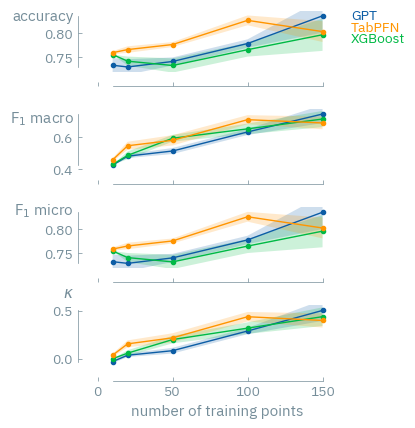

In [31]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(
    4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
)

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[ :].index,
        grouped_res.loc[:][metric]["mean"],
        marker="o",
        label="GPT",
    )
    ax[i].fill_between(
        grouped_res.loc[ :].index,
        grouped_res.loc[:][metric]["mean"] - grouped_res.loc[ :][metric]["sem"],
        grouped_res.loc[ :][metric]["mean"] + grouped_res.loc[ :][metric]["sem"],
        alpha=0.2,
    )

    range_frame(
        ax[i],
        grouped_res.loc[ :].index,
        np.stack([
            grouped_res.loc[:][metric]["mean"],
              grouped_xgboost_res.loc[ :][metric]["mean"],
              grouped_tabpfn_res.loc[ :][metric]["mean"], 
        ]).flatten()
    )

    ax[i].plot(
        grouped_xgboost_res.loc[ :].index,
        grouped_xgboost_res.loc[ :][metric]["mean"],
        marker="o",
        label="XGBoost",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[ :].index,
        grouped_xgboost_res.loc[:][metric]["mean"]
        - grouped_xgboost_res.loc[ :][metric]["sem"],
        grouped_xgboost_res.loc[:][metric]["mean"]
        + grouped_xgboost_res.loc[:][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[ :].index,
        grouped_tabpfn_res.loc[ :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[ :].index,
        grouped_tabpfn_res.loc[:][metric]["mean"]
        - grouped_tabpfn_res.loc[ :][metric]["sem"],
        grouped_tabpfn_res.loc[ :][metric]["mean"]
        + grouped_tabpfn_res.loc[:][metric]["sem"],
        alpha=0.2,
    )

ylabel_top("accuracy", ax=ax[0], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], x_pad=0.05, y_pad=0.06)
ylabel_top(r"$\kappa$", ax=ax[3], x_pad=0.05, y_pad=0.06)
ax[-1].set_xlabel("number of training points", labelpad=4)
matplotx.line_labels(ax=ax[0])
plt.subplots_adjust(hspace=.6, top=1, bottom=.2)

fig.savefig("mof_water_stability.pdf", bbox_inches="tight")

In [38]:
find_learning_curve_intersection(
    grouped_res.loc[:]["f1_macro"]["mean"].values[1],
    fit_learning_curve(
        grouped_xgboost_res.loc[:].index,
        grouped_xgboost_res.loc[ :]["f1_macro"]["mean"],
    )[0],
) / grouped_res.loc[:]["f1_macro"]["mean"].index[1]

0.7750074140458505

In [ ]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

KeyError: 2